In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
from skimage import io
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.utils import class_weight
 
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
 
import warnings
warnings.simplefilter("ignore")
 
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [ ]:
# To check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Download Data using Kaggle API

https://www.kaggle.com/docs/api

https://www.kaggle.com/general/74235

## Coco Dataset

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle                 #make directory(folder) named .kaggle
 
! cp /content/drive/MyDrive/Datasets/kaggle.json ~/.kaggle/       #copy file to folder
 
! chmod 600 ~/.kaggle/kaggle.json        #Change the permissions of the file.

In [ ]:
! kaggle datasets download oishee30/cocopersonsegmentation

print(os.listdir('/content'))

100% 8.19G/8.20G [03:34<00:00, 53.4MB/s]
100% 8.20G/8.20G [03:34<00:00, 41.0MB/s]
['.config', 'drive', 'cocopersonsegmentation.zip', 'sample_data']


In [ ]:
start = datetime.now()
! mkdir data        #making directory data
 
! unzip cocopersonsegmentation.zip -d data           #unzipping data into data directory 
 
end = datetime.now()
print("time taken to unzip:",end -start)

In [ ]:
os.remove('cocopersonsegmentation.zip')
print(os.listdir('/content'))

['.config', 'drive', 'data', 'sample_data']


In [ ]:
os.listdir('/content/data')

['val2017_new', 'val2017_ann', 'train2017_new', 'codes.txt', 'train2017_ann']

In [ ]:
path = '/content/data'
for folder in os.listdir(path):
  if '.txt' not in folder:
    print('No of images in',folder,len(os.listdir(path+'/'+folder)))

No of images in val2017_new 2693
No of images in val2017_ann 2693
No of images in train2017_new 64115
No of images in train2017_ann 64115


# Prepare Datset for training



In [ ]:
xpath_coco = '/content/data/train2017_new/'
ypath_coco = '/content/data/train2017_ann/'
x_test_path = '/content/data/val2017_new/'
y_test_path = '/content/data/val2017_ann/'

In [ ]:
input_img_paths_coco = sorted([os.path.join(xpath_coco, fname) for fname in os.listdir(xpath_coco)])
target_img_paths_coco = sorted([os.path.join(ypath_coco, fname) for fname in os.listdir(ypath_coco)])
 
print(len(input_img_paths_coco), len(target_img_paths_coco))
for input_path, target_path in zip(input_img_paths_coco[:4], target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

64115 64115
/content/data/train2017_new/000000000036.jpg | /content/data/train2017_ann/000000000036.jpg
/content/data/train2017_new/000000000049.jpg | /content/data/train2017_ann/000000000049.jpg
/content/data/train2017_new/000000000061.jpg | /content/data/train2017_ann/000000000061.jpg
/content/data/train2017_new/000000000074.jpg | /content/data/train2017_ann/000000000074.jpg


In [ ]:
test_input_img_paths_coco = sorted([os.path.join(x_test_path, fname) for fname in os.listdir(x_test_path)])
test_target_img_paths_coco = sorted([os.path.join(y_test_path, fname) for fname in os.listdir(y_test_path)])
 
print(len(test_input_img_paths_coco), len(test_target_img_paths_coco))
for input_path, target_path in zip(test_input_img_paths_coco[:4], test_target_img_paths_coco[:4]):
    print(input_path, "|", target_path)

2693 2693
/content/data/val2017_new/000000000139.jpg | /content/data/val2017_ann/000000000139.jpg
/content/data/val2017_new/000000000785.jpg | /content/data/val2017_ann/000000000785.jpg
/content/data/val2017_new/000000000872.jpg | /content/data/val2017_ann/000000000872.jpg
/content/data/val2017_new/000000000885.jpg | /content/data/val2017_ann/000000000885.jpg


In [ ]:
train_input_img_paths = input_img_paths_coco.copy()
train_target_img_paths = target_img_paths_coco.copy()
 
val_input_img_paths = test_input_img_paths_coco.copy()
val_target_img_paths = test_target_img_paths_coco.copy()
 
print(len(train_input_img_paths), len(train_target_img_paths))
print(len(val_input_img_paths), len(val_target_img_paths))

64115 64115
2693 2693


In [ ]:
'''
samples = 500
 
train_input_img_paths = train_input_img_paths[:samples]
train_target_img_paths = train_target_img_paths[:samples]
 
val_input_img_paths = val_input_img_paths[:250]
val_target_img_paths = val_target_img_paths[:250]

'''

'\nsamples = 500\n \ntrain_input_img_paths = train_input_img_paths[:samples]\ntrain_target_img_paths = train_target_img_paths[:samples]\n \nval_input_img_paths = val_input_img_paths[:250]\nval_target_img_paths = val_target_img_paths[:250]\n\n'

In [ ]:
#shuffle image paths
import random
random.seed(0)
 
ziped_list = list(zip(train_input_img_paths, train_target_img_paths))
 
random.shuffle(ziped_list)                          #shuffle, it will shuffle the list and return none.
 
ziped_list[:4]

[('/content/data/train2017_new/000000081357.jpg',
  '/content/data/train2017_ann/000000081357.jpg'),
 ('/content/data/train2017_new/000000441929.jpg',
  '/content/data/train2017_ann/000000441929.jpg'),
 ('/content/data/train2017_new/000000266831.jpg',
  '/content/data/train2017_ann/000000266831.jpg'),
 ('/content/data/train2017_new/000000396890.jpg',
  '/content/data/train2017_ann/000000396890.jpg')]

In [ ]:
unziped_list = list(zip(*ziped_list))
len(unziped_list)

2

In [ ]:
train_input_img_paths = unziped_list[0]
train_target_img_paths = unziped_list[1]
 
print("Number of training samples input:", len(train_input_img_paths))
print("Number of training samples labels:", len(train_target_img_paths))
 
for input_path, target_path in zip(train_input_img_paths[:4], train_target_img_paths[:4]):
    print(input_path, "|", target_path)

Number of training samples input: 64115
Number of training samples labels: 64115
/content/data/train2017_new/000000081357.jpg | /content/data/train2017_ann/000000081357.jpg
/content/data/train2017_new/000000441929.jpg | /content/data/train2017_ann/000000441929.jpg
/content/data/train2017_new/000000266831.jpg | /content/data/train2017_ann/000000266831.jpg
/content/data/train2017_new/000000396890.jpg | /content/data/train2017_ann/000000396890.jpg


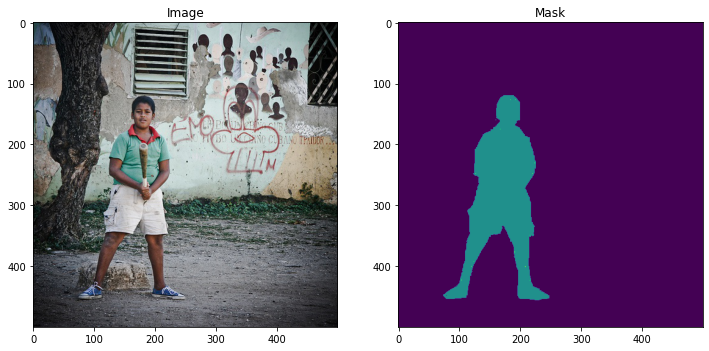

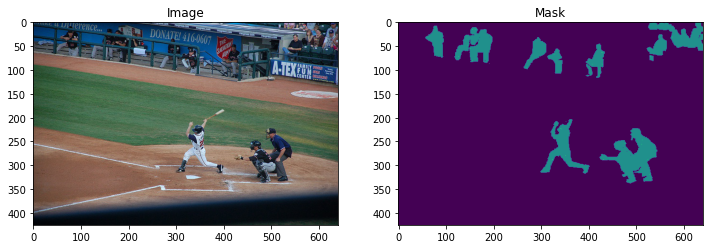

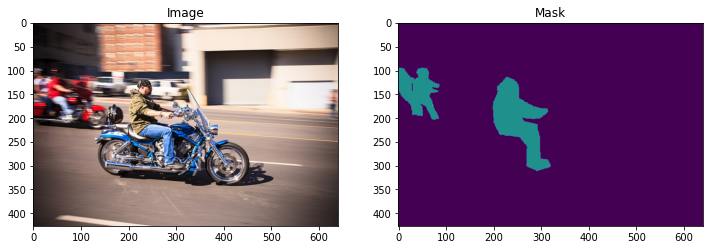

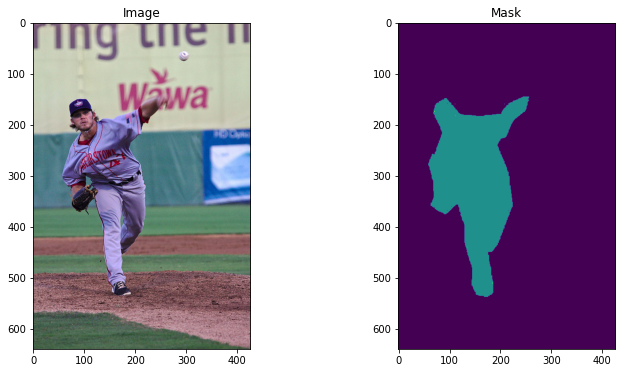

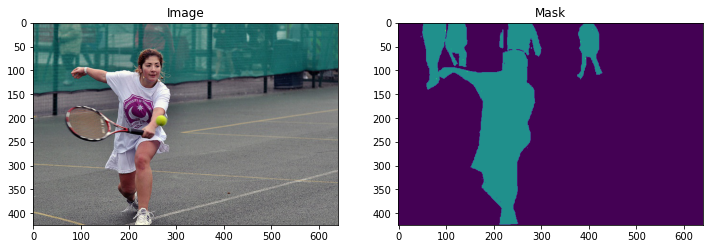

In [ ]:
n_images = 5
for i in np.random.randint(0,len(train_input_img_paths),n_images):
 
  fig = plt.figure(figsize=(12,6))
  fig.tight_layout()
 
  plt.subplot(1,2,1)
  img = plt.imread(train_input_img_paths[i])
  plt.imshow(img)
  plt.title('Image')
 
  plt.subplot(1,2,2)
  img = plt.imread(train_target_img_paths[i])
  plt.imshow(img)
  plt.title('Mask')
 
  plt.show()
  print()

(array([0, 1, 2], dtype=uint8), array([164695, 142497,      8]))
(640, 480)


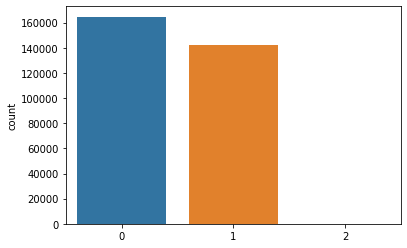

In [ ]:
mask = plt.imread(train_target_img_paths[0])
print(np.unique(mask, return_counts= True))
print(mask.shape)
sns.countplot(mask.ravel())
plt.show()

# Full Dataset - Model 6 

In [ ]:
class Data_Generator(keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
       
 
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size                    # 64115//32
 
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to batch #index.
        """
 
        iterator = index * self.batch_size                                                            # 0
        batch_input_img_paths = self.input_img_paths[iterator : iterator + self.batch_size]                # [0: 0+32]
        batch_target_img_paths = self.target_img_paths[iterator : iterator + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")           #(32,256,256,3)
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            img = np.array(img)/255
            x[j] = img
 
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")             #(32,256,256,1)
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")        #(256,256)
            img = np.array(img)
            img[img!=0] = 1
            y[j] = np.expand_dims(img, 2)                                                  #(256,256,1)
 
        class_weights = class_weight.compute_class_weight('balanced', np.unique(y.ravel()),  y.ravel())
        class_weights = class_weights/np.sum(class_weights)
        sample_weights = tf.gather(class_weights, indices = tf.cast(y, tf.int32))
 
        return x, y, sample_weights

In [ ]:
# Gererator function
batch_size = 32
img_size = (256,256)
 
train_gen = Data_Generator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Data_Generator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
x, y, sw = train_gen.__getitem__(0)
print(type(sw))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
sw.shape

TensorShape([32, 256, 256, 1])

In [ ]:
train_gen.__len__()

2003

In [ ]:
def downblock(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
 
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)
 
  return x,p
 
def bottleneck(filters, filter_size, previous_layer, dropout = True):
  x = layers.BatchNormalization()(previous_layer)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
 
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
 
  return x
 
def upblock(filters, filter_size, previous_layer, layer_to_concat, dropout = True):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation
 
  x = layers.BatchNormalization()(concat)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  
  if dropout:
    x = layers.Dropout(0.2)(x)
 
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
   
  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addition
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)
 
  return x

In [ ]:
def create_model():
    input_layer = layers.Input(shape = img_size + (3,))

    layer1 = layers.Conv2D(16, 3, padding="same")(input_layer)
    
    conv1, pool1 = downblock(32, 3, layer1, dropout = True)
    conv2, pool2 = downblock(64, 3, pool1, dropout = True)
    conv3, pool3 = downblock(128, 3, pool2, dropout = True)
    conv4, pool4 = downblock(256, 3, pool3, dropout = True)
    
    conv5 = bottleneck(512,3,pool4, dropout = True)
    
    upconv1 = upblock(256, 3, conv5, conv4, dropout = True)
    upconv2 = upblock(128, 3, upconv1, conv3, dropout = True)
    upconv3 = upblock(64, 3, upconv2, conv2, dropout = True)
    upconv4 = upblock(32, 3, upconv3, conv1, dropout = True)
    
    output_layer = layers.Conv2D(1, 1, padding="same", activation='sigmoid')(upconv4)
    
    model = keras.Model(input_layer, output_layer)
    
    return model

In [ ]:
#model = create_model()
#model.summary()

In [ ]:
class mIOU():
    def __init__(self,threshold = 0.5):
        self.threshold = threshold
        self.iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
 
    def mean_iou(self, y_true, y_pred):
        y_true_ = tf.cast(y_true, tf.int32)
        y_pred_ = tf.cast(y_pred > self.threshold, tf.int32)
        
        self.iou_metric.update_state(y_true_, y_pred_)
        
        return self.iou_metric.result()

In [ ]:
iou = mIOU()
 
modelpath = '/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch_6_val_loss_0.056177_val_mean_iou_0.794168.h5'
 
model = tf.keras.models.load_model(modelpath, custom_objects={"mean_iou": iou.mean_iou})

In [ ]:
# load json and create model
json_file = open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch7.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch7.h5")

In [ ]:
iou = mIOU()
opt = Adam(0.0001)      #learning_rate=0.001
 
model.compile(optimizer=opt,
            loss="binary_crossentropy",
            metrics=['accuracy', iou.mean_iou]) 
 
filepath = "/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch_8_val_loss_{val_loss:03f}_val_mean_iou_{val_mean_iou:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
start = datetime.now()
 
# Train the model, doing validation at the end of each epoch.
epochs = 1
model_history = model.fit(train_gen,
                          epochs = epochs,
                          validation_data = val_gen,
                          callbacks=callbacks)        #, callbacks=callbacks)
 
end = datetime.now()
print(f'Time take to train {epochs} epochs is:', end - start)

2003/2003 [==============================] - 4137s 2s/step - loss: 0.0418 - accuracy: 0.9309 - mean_iou: 0.8055 - val_loss: 0.0549 - val_accuracy: 0.9136 - val_mean_iou: 0.8057
Time take to train 1 epochs is: 1:08:58.586421


In [ ]:
history_epoch8 = model_history.history
history_epoch8

{'accuracy': [0.9309313893318176],
 'loss': [0.041795067489147186],
 'mean_iou': [0.8054917454719543],
 'val_accuracy': [0.9135721921920776],
 'val_loss': [0.054934512823820114],
 'val_mean_iou': [0.8056907653808594]}

In [ ]:
history_epoch7 = model_history.history
history_epoch7

{'accuracy': [0.9291614294052124],
 'loss': [0.042775776237249374],
 'mean_iou': [0.7990626096725464],
 'val_accuracy': [0.9095972776412964],
 'val_loss': [0.055867355316877365],
 'val_mean_iou': [0.8017021417617798]}

In [ ]:
history_epoch6 = model_history.history
history_epoch6

{'accuracy': [0.9256927967071533],
 'loss': [0.04484694078564644],
 'mean_iou': [0.7878526449203491],
 'val_accuracy': [0.907028317451477],
 'val_loss': [0.05617682635784149],
 'val_mean_iou': [0.7941675782203674]}

In [ ]:
history_epoch5 = model_history.history
history_epoch5

{'accuracy': [0.9118724465370178],
 'loss': [0.05303901433944702],
 'mean_iou': [0.7638500928878784],
 'val_accuracy': [0.89704829454422],
 'val_loss': [0.06113000586628914],
 'val_mean_iou': [0.7656009197235107]}

In [ ]:
history_epoch4 = model_history.history
history_epoch4

{'accuracy': [0.8938235640525818],
 'loss': [0.061583466827869415],
 'mean_iou': [0.7285050749778748],
 'val_accuracy': [0.8904183506965637],
 'val_loss': [0.06799568235874176],
 'val_mean_iou': [0.7316431999206543]}

In [ ]:
history_epoch3 = model_history.history
history_epoch3

{'accuracy': [0.8927916288375854],
 'loss': [0.06279353052377701],
 'mean_iou': [0.7254215478897095],
 'val_accuracy': [0.8266280889511108],
 'val_loss': [0.08652841299772263],
 'val_mean_iou': [0.7277508974075317]}

In [ ]:
history_epoch2 = model_history.history
history_epoch2

{'accuracy': [0.8764503002166748],
 'loss': [0.07148265093564987],
 'mean_iou': [0.6915450692176819],
 'val_accuracy': [0.8365141749382019],
 'val_loss': [0.0856541097164154],
 'val_mean_iou': [0.7001632452011108]}

In [ ]:
history1 = model_history.history 
history1 

{'accuracy': [0.8185955882072449],
 'loss': [0.09707339853048325],
 'mean_iou': [0.5632995963096619],
 'val_accuracy': [0.8076751232147217],
 'val_loss': [0.09329662472009659],
 'val_mean_iou': [0.6152238845825195]}

In [ ]:
def plot_result(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    train_iou = history['mean_iou']
    val_iou = history['val_mean_iou']
 
    plt.figure(figsize=(16,6))
 
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r', label='Training loss')
    plt.plot(val_loss, 'b', label='Validation loss')
    plt.text(len(train_loss)-4, train_loss[-1]-0.05, str(round(train_loss[-1], 3)), color = 'black')
    plt.text(len(val_loss)-4, val_loss[-1]-0.05, str(round(val_loss[-1], 3)), color = 'black')
 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    #plt.yticks(np.arange(0, 1.1,.05))
    plt.legend()
 
    plt.subplot(1,3,2)
    plt.plot(train_acc, 'r', label='Training acc')
    plt.plot(val_acc, 'b', label='Validation acc')
    plt.text(len(train_acc)-4, train_acc[-1]-0.04, str(round(train_acc[-1], 3)), color = 'black')
    plt.text(len(val_acc)-4, val_acc[-1]-.04, str(round(val_acc[-1], 3)), color = 'black')
 
    plt.title('Training and Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.yticks(np.arange(0, 1.05, .05))
    plt.legend()
 
    plt.subplot(1,3,3)
    plt.plot(train_iou, 'r', label='Training mean_iou')
    plt.plot(val_iou, 'b', label='Validation mean_iou')
    plt.text(len(train_iou)-4, train_iou[-1]-.05, str(round(train_iou[-1], 3)), color = 'black')
    plt.text(len(val_iou)-4, val_iou[-1]-.05, str(round(val_iou[-1], 3)), color = 'black')
 
    plt.title('Training and Validation mean_io_u')
    plt.xlabel('Epoch')
    plt.ylabel('mean_iou')
    plt.yticks(np.arange(0, .8, .04))
    plt.legend()
    plt.show()

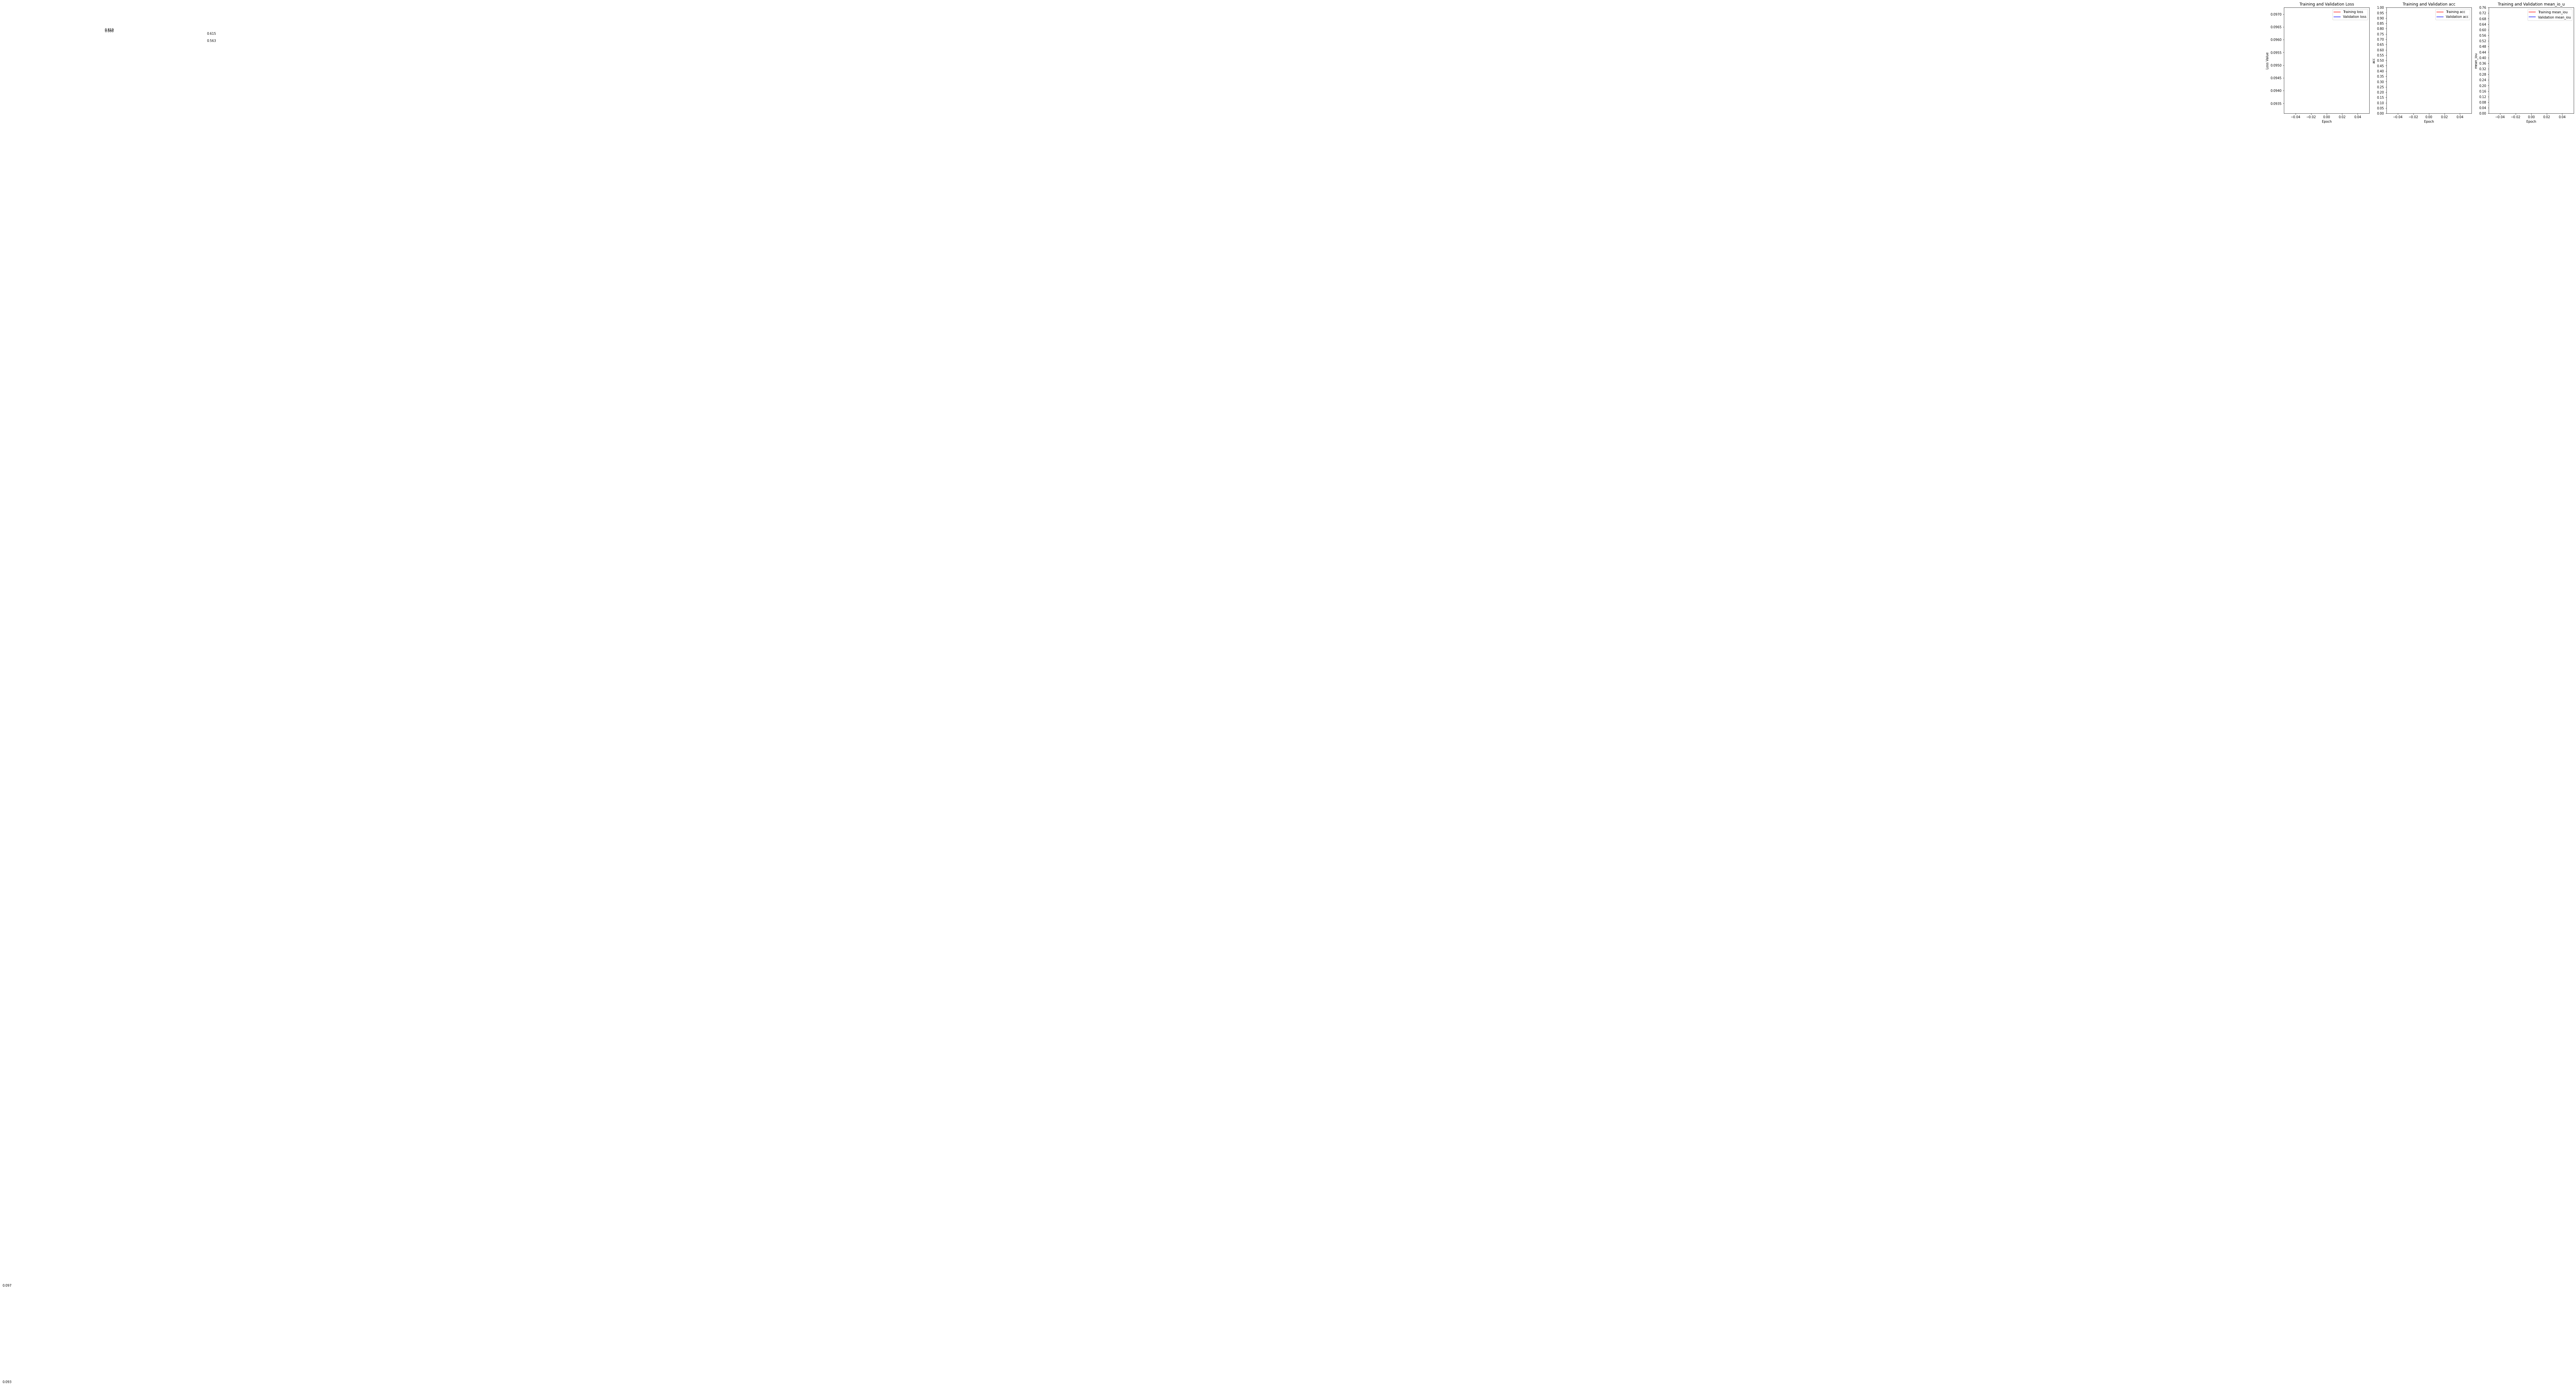

In [ ]:
plot_result(history)

In [ ]:
import json
with open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_results_epoch8.json', 'w') as fp:
    json.dump(history_epoch8, fp)

# Testing

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class mIOU():
    def __init__(self,threshold = 0.5):
        self.threshold = threshold
        self.iou_metric = tf.keras.metrics.MeanIoU(num_classes = 2)
 
    def mean_iou(self, y_true, y_pred):
        y_true_ = tf.cast(y_true, tf.int32)
        y_pred_ = tf.cast(y_pred > self.threshold, tf.int32)
        
        self.iou_metric.update_state(y_true_, y_pred_)
        
        return self.iou_metric.result()

In [ ]:
miou = mIOU()

In [ ]:
modelpath = '/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch_5_val_loss_0.061130_val_mean_iou_0.765601.h5'
 
model1 = tf.keras.models.load_model(modelpath, custom_objects={"mean_iou": miou.mean_iou})

In [ ]:
model1.evaluate(val_gen)

84/84 [==============================] - 74s 866ms/step - loss: 0.0611 - accuracy: 0.8970 - mean_iou: 0.7514


[0.06113000586628914, 0.8970484137535095, 0.7514480948448181]

In [ ]:
model.save_weights('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch8.h5')

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch8.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load json and create model
json_file = open('/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch8.h5")

In [ ]:
iou = mIOU(.5)
opt = Adam(0.0001)      #learning_rate=0.001
 
loaded_model.compile(optimizer=opt,
            loss="binary_crossentropy",
            metrics=['accuracy', iou.mean_iou])
 
filepath = "/content/drive/MyDrive/AI_Notebooks_and_Models/Background_Remover/model6_fulldata_epoch_6_val_loss_{val_loss:03f}_val_mean_iou_{val_mean_iou:03f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only= False)
 
callbacks = [checkpoint]

In [ ]:
#epoch 8 threshold 0.5
loaded_model.evaluate(val_gen)

84/84 [==============================] - 76s 883ms/step - loss: 0.0549 - accuracy: 0.9136 - mean_iou: 0.7786


[0.054934512823820114, 0.9135721921920776, 0.7786048650741577]

In [ ]:
#epoch 7 threshold .85
loaded_model.evaluate(val_gen)

84/84 [==============================] - 75s 867ms/step - loss: 0.0559 - accuracy: 0.9096 - mean_iou: 0.8246


[0.055867355316877365, 0.9095972776412964, 0.8246043920516968]

In [ ]:
img_size = (256,256)
def ploting(imgpath, maskpath, threshold = .7):
  plt.figure(figsize=(12,4))
 
  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)/255
 
  plt.subplot(1,3,1)
  plt.title('Original')
  plt.imshow(im)
 
  im = im.reshape((1,)+im.shape)
  im.shape
 
  pred = model.predict(im)
  
  p = pred.copy()
  p = p.reshape(p.shape[1:-1])
 
  p[np.where(p>threshold)] = 1
  p[np.where(p<threshold)] = 0
 
  im = io.imread(imgpath)
  im = cv2.resize(im,img_size)
  im = np.array(im)
 
  im[:,:,0] = im[:,:,0]*p 
  im[:,:,0][np.where(p!=1)] = 247
  im[:,:,1] = im[:,:,1]*p 
  im[:,:,1][np.where(p!=1)] = 231
  im[:,:,2] = im[:,:,2]*p
  im[:,:,2][np.where(p!=1)] = 230
 
  plt.subplot(1,3,2)
  plt.imshow(im)
  
  if maskpath:
    plt.subplot(1,3,3)
    mask = io.imread(maskpath)
    mask = cv2.resize(mask,img_size)
    plt.imshow(mask)
 
  plt.show()

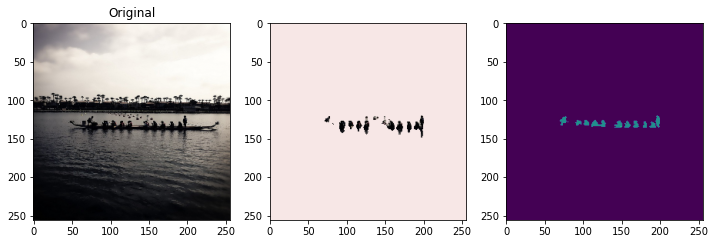

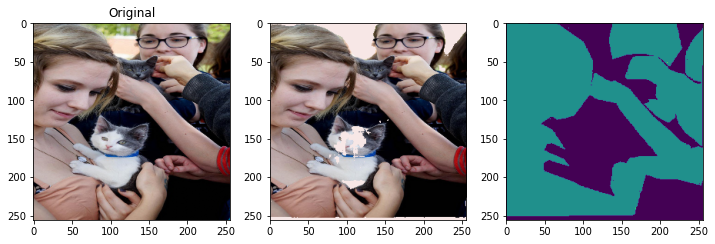

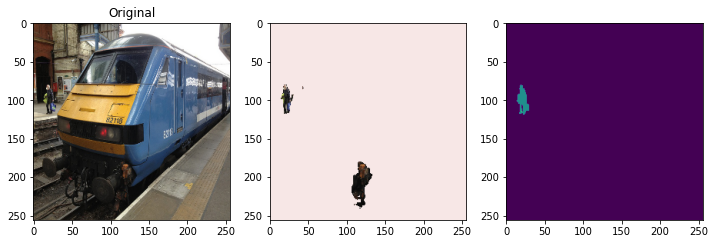

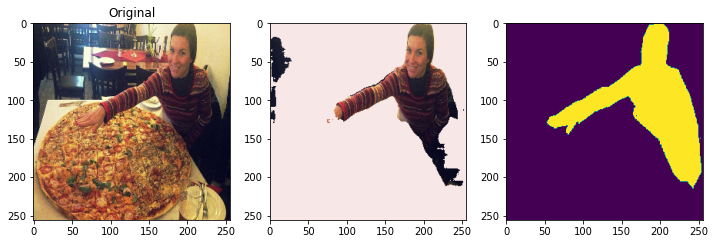

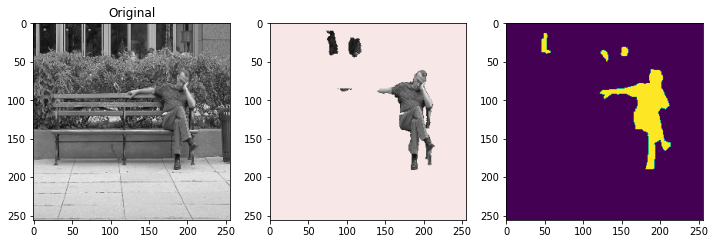

In [ ]:
n_images = 5
for i in np.random.randint(0,len(train_input_img_paths),n_images):
  ploting(train_input_img_paths[i],
          train_target_img_paths[i],
          .8)

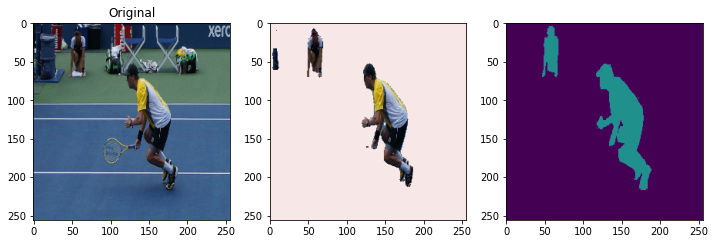

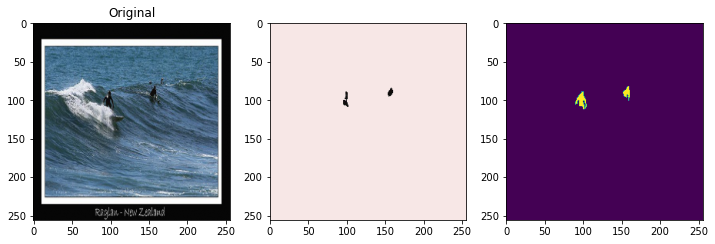

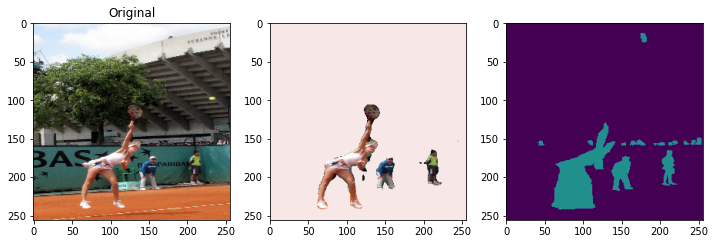

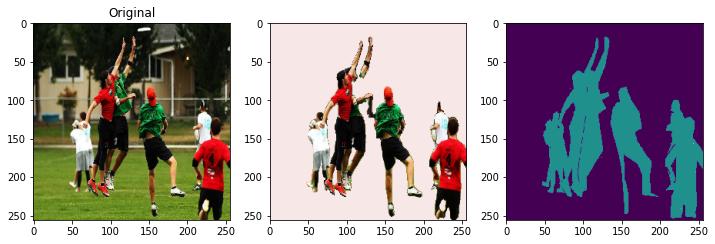

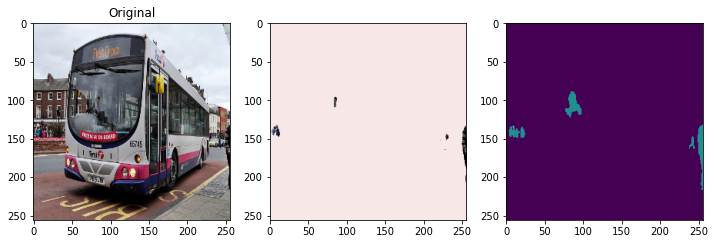

In [ ]:
n_images = 5
for i in np.random.randint(0,len(val_input_img_paths),n_images):
  ploting(val_input_img_paths[i],
          val_target_img_paths[i],
          .8)

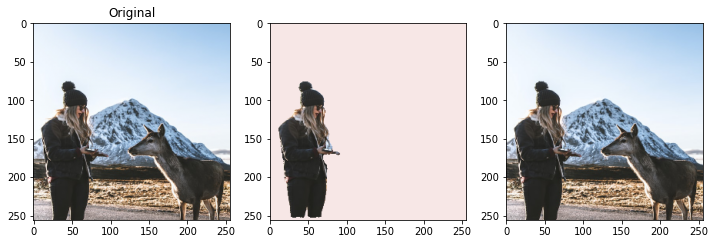

In [ ]:
ploting('https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/hibuddy.jpg',
        'https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/hibuddy.jpg',
        .85)

In [ ]:
ploting('/content/zoomed.jpg','/content/zoomed.jpg', .85)

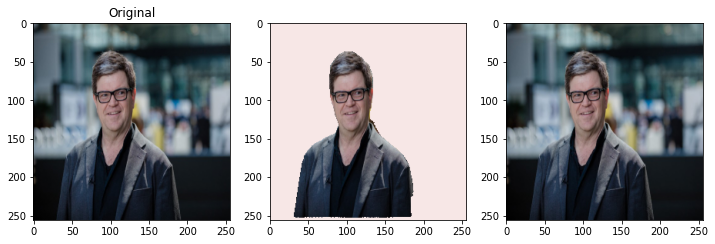

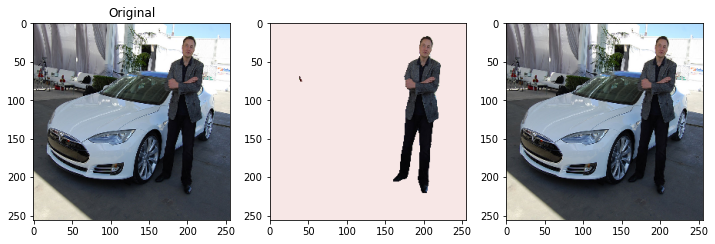

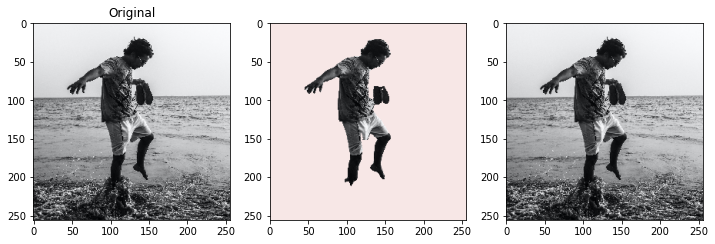

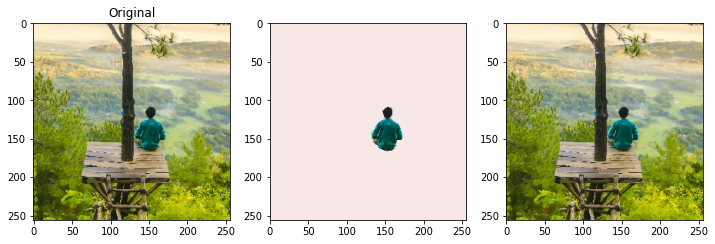

In [ ]:
for i in ['https://harvardmagazine.com/sites/default/files/styles/4x3_main/public/img/article/0919/hm_post_9.18.2019.jpg?itok=74R4n9pd',
          'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Elon_Musk%2C_Tesla_Factory%2C_Fremont_%28CA%2C_USA%29_%288765031426%29.jpg/800px-Elon_Musk%2C_Tesla_Factory%2C_Fremont_%28CA%2C_USA%29_%288765031426%29.jpg',
          'https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/cool.jpg',
          'https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/relax.jpg']:
    ploting(i, i, .9)

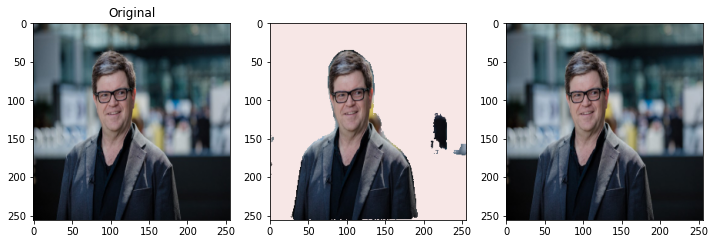

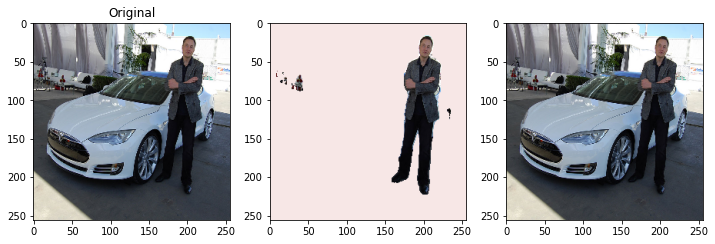

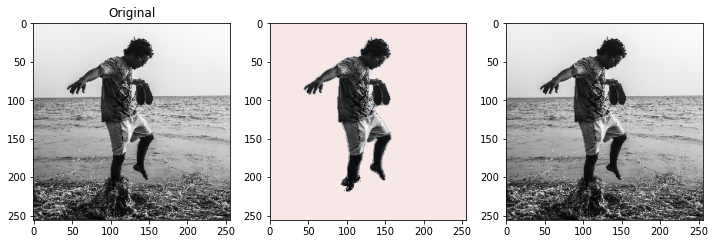

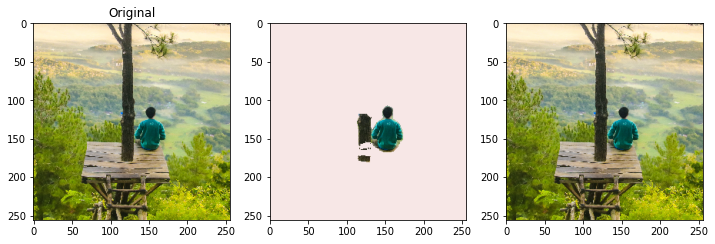

In [ ]:
for i in ['https://harvardmagazine.com/sites/default/files/styles/4x3_main/public/img/article/0919/hm_post_9.18.2019.jpg?itok=74R4n9pd',
          'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Elon_Musk%2C_Tesla_Factory%2C_Fremont_%28CA%2C_USA%29_%288765031426%29.jpg/800px-Elon_Musk%2C_Tesla_Factory%2C_Fremont_%28CA%2C_USA%29_%288765031426%29.jpg',
          'https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/cool.jpg',
          'https://raw.githubusercontent.com/G0rav/Automatic_Background_Removal/main/src/Testing%20samples/relax.jpg']:
    ploting(i, i, .5)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
!curl -o sample.mp4 https://www.sample-videos.com/video123/mp4/720/big_buck_bunny_720p_1mb.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (51) SSL: no alternative certificate subject name matches target host name 'www.sample-videos.com'


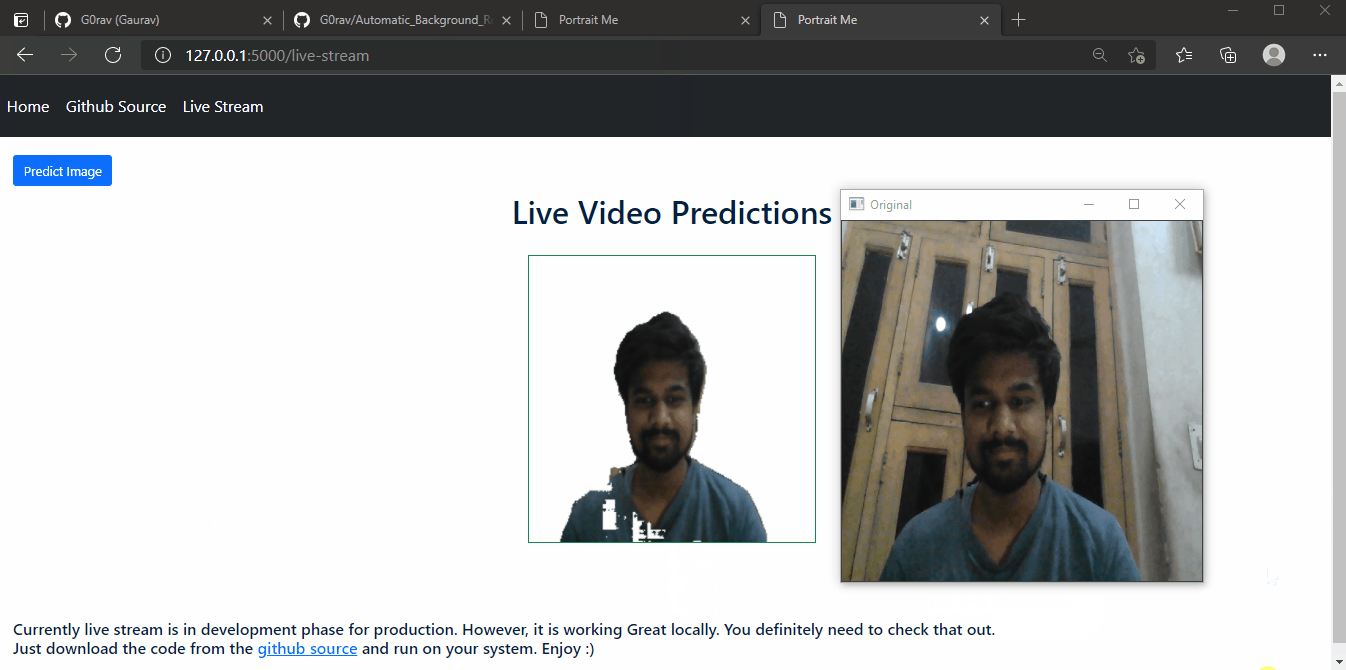

error: ignored

In [ ]:
from IPython.display import clear_output, Image
import base64

def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

video_capture = cv2.VideoCapture('/content/Demo.gif')
while video_capture.isOpened():
    success, frame = video_capture.read()

    clear_output(wait=True)
    img = arrayShow(frame)
    display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# END